In [1]:
import math
import random
import matplotlib.pyplot as plt

# ==================== Review ====================

## 問題描述：

假設有台老虎機，上面有 K 個手臂，拉動任一手臂 i $ (i = 0,2,...,K-1)$，可獲得的報酬為 $\{1, 0\}$，
但是獲得報酬的機率只有 $p_i$，即 $P(r_i=1) = p_i$ 和 $P(r_i=0) = 1-p_i$。


假設現在要拉 T 次，目標是最大化報酬，請擬定策略。

## 衡量標準：

這裡我們用 Average Regrets，denoted by $E[L(t)]$，來衡量策略好壞


### Regrets 的定義：
$$ L(t) = V - p(I_t)$$

$V$ : 機率 $p_i$ 最大那台機器的機率, i.e., $V = max_i$ $p_i$

$p(I_t)$: 在 t 時間如果選擇了 i 機器，則 $p(I_t=i) = p_i$

### Average Regrets 的定義：
$$ E[L(t)] = \frac{1}{N} \sum_{s=1}^{N} L_s(t) $$

$L_s(t)$ 代表在第 s 回合實驗得到的 Regrets。上面的意思是說，做 N 回合實驗後，對 N 個 Lt 取平均。


### 備註：
這裡假設老虎機會幫我們記錄 $V-p(I_t)$，這是因為只有老虎機知道 $V$ 和 $p_i$

## 作業三要實現的策略：
1. Random
2. Greedy
3. Epsilon-greedy
4. Optimistic Initial Values
5. Upper Confidence Bound (UCB)

## 作業四要實現的策略：
6. mu + c * sigma / sqrt(N) ＃ 這裡 N 代表機器被選到的數目
7. Thompson Sampling
8. Bayesian Thompson Sampling

# ==================== 老虎機 ====================

In [2]:
class Bandit:
    def __init__(self, arms_number):
        random.seed()                                                   # 根據電腦時間設定隨機種子
        self.arms_number = arms_number                                  # 手臂數目
        self.probs = [random.uniform(0, 1) for _ in range(arms_number)] # 各手臂獲得報酬的機率
        self.max_prob = max(self.probs)                                 # 最大機率值
        self.best_arm_id = self.probs.index(self.max_prob)              # 最大機率的那隻手臂的 id
        self.accum_regrets = list()                                     # 幫忙記錄 accumulated regret

    def pull_an_arm(self, arm_id):
        """手臂被拉動，以機率 P(ri=1) = pi 和 P(ri=0) = 1-pi 回傳報酬。"""
        # --- get reward from the arm with id of arm_id ---
        pi = self.probs[arm_id]
        if random.uniform(0, 1) <= pi:
            reward = 1
        else:
            reward = 0
        # --- record the accumulated regrets (請老虎機幫忙記錄一下 regrets) ---
        if len(self.accum_regrets) == 0:
            last_accum_regrets = 0
        else:
            last_accum_regrets = self.accum_regrets[-1]       
        self.accum_regrets.append(last_accum_regrets + self.max_prob - pi)
        return reward
    
    def reset_regret_information(self):
        self.accum_regrets = list()

# ==================== 玩家 ====================
### 備註：
以下策略的程式的呈現以方便讀者理解策略思路為優先，不考慮程式執行時間和空間的節省，大家在寫作業的時候可以把這些因素考慮進來，例如使用 numpy 來做計算和利用上一時間已經算過的數值

In [3]:
class Player:
    def __init__(self, arms_number):
        self.arms_number = arms_number                  # 手臂數目
        self.rewards = [[] for _ in range(arms_number)] # self.rewards[i]：list，儲存ith機器的歷史報酬

    def reset_reward_information(self):
        self.rewards = [[] for _ in range(self.arms_number)]
    
    def update_reward_information(self, arm_id, reward):
        if isinstance(reward, list):
            self.rewards[arm_id].extend(reward)
        else:
            self.rewards[arm_id].append(reward)

    # ---------------------------- 策略函數: 都是回傳老虎機的手臂id --------------------------------
    def choose_an_arm_by_random(self, **kwargs):
        """隨便選一支手臂並回傳。"""
        return random.choice(range(self.arms_number))

    def choose_an_arm_by_greedy(self, **kwargs):
        """根據目前各手臂的平均報酬，選擇最高的回傳其id。"""
        average_rewards = self._get_average_rewards()
        return average_rewards.index(max(average_rewards))

    def choose_an_arm_by_epsilon_greedy(self, epsilon):
        """根據目前各手臂的平均報酬和設定的機率選擇手臂。
        
        以 1 - epsilon + epsilon/arms_number 的機率選擇目前平均報酬最高的手臂
        以 epsilon/arms_number 的機率選擇非平均報酬最高的手臂
        """
        if epsilon < 0 or epsilon > 1:
            raise ValueError('The value of epsilon must be between [0, 1]') 
        
        arm_id_with_max_reward = self.choose_an_arm_by_greedy()     # 目前最高平均報酬的手臂 id
        rest_arm_id = list(set(range(self.arms_number)) - set({arm_id_with_max_reward})) # 其他手臂 ids
        
        prob_for_best_arm = 1 - epsilon + epsilon/self.arms_number  # 選擇目前平均報酬最高手臂的機率
        if random.uniform(0, 1) <= prob_for_best_arm:
            be_chosen_arm_id = arm_id_with_max_reward
        else:
            be_chosen_arm_id = random.choice(rest_arm_id)
        return be_chosen_arm_id

    def choose_an_arm_by_optimistic_initial_value(self, initial_value):
        """取各手臂的目前累積報酬和初始值的平均，回傳最大平均值的手臂id。"""
        average_rewards = [0] * self.arms_number
        for i in range(self.arms_number):
            size = len(self.rewards[i])                             # ith 手臂目前被拉了幾次
            if size > 0:                                            # ith 手臂可能沒被選過
                average_rewards[i] = (initial_value + sum(self.rewards[i])) / (size + 1)
            else:
                average_rewards[i] = initial_value
        return average_rewards.index(max(average_rewards))

    def choose_an_arm_by_average_reward_plus_std(self, multiplier, initial_value):
        """選擇手臂根據它們的 mu + c * sigma / sart(N).
        
        這裡也需要使用 initial_value
        同於樂觀初始值的手法，用以解決需要多跑幾輪隨機策略的問題，
        不然沒有資料的情況下，mu = 0，sigma = 0，會造成選擇卡在一開始有值的手臂。
        """
        average_reward_plus_std = [0] * self.arms_number
        for i in range(self.arms_number):
            size = len(self.rewards[i])

            # --- average reward ---
            mu = initial_value
            for j in range(size):
                mu += self.rewards[i][j]
            mu = mu / (size + 1) 
            
            # --- variance ---
            variance = (initial_value - mu) ** 2
            for j in range(size):
                variance += (self.rewards[i][j] - mu) ** 2
            variance = variance / (size + 1)
            sigma = variance ** 0.5
            
            average_reward_plus_std[i] = mu + multiplier * sigma / ((size + 1) ** 0.5)
        return average_reward_plus_std.index(max(average_reward_plus_std))
    
    def choose_an_arm_by_upper_confidence_bound(self, upper_bound, lower_bound):
        """根據 UCB 策略回傳手臂id，取以下公式最大值的手臂id。
        
        公式： average_reward 
            + (upper_bound - lower_bound) * sqrt( 2 * log(num_total_pulls) / num_pulls)
        """
        # --- get the number of total pulls ---
        num_total_pulls = 0
        for rewards_i in self.rewards:
            num_total_pulls += len(rewards_i)
        
        # --- 如果沒有機器被選過，就隨機選一台 ---
        if num_total_pulls == 0:
            return self.choose_an_arm_by_random()

        # --- UCB 演算法 ---
        ucb_values = [0] * self.arms_number
        average_rewards = self._get_average_rewards()
        delta = upper_bound - lower_bound
        for i in range(self.arms_number):
            num_pulls = len(self.rewards[i])    # ith 手臂被拉了幾次
            ucb_values[i] = average_rewards[i] \
                + delta * ( 2 * math.log(num_total_pulls) / (num_pulls+1e-6) )**0.5
        return ucb_values.index(max(ucb_values))

    # ---------------------------- 工具函數 --------------------------------
    def _get_average_rewards(self):
        average_rewards = [0] * self.arms_number
        for i in range(self.arms_number):
            size = len(self.rewards[i])                             # ith 手臂目前被拉了幾次
            if size > 0:                                            # ith 手臂可能沒被選過
                average_rewards[i] = sum(self.rewards[i]) / size    # ith 手臂目前累積的平均報酬
        return average_rewards


# ================= 實驗玩家的策略 =================

In [4]:
def get_accum_regrets_with_runs_and_times(bandit, player, number_of_runs, number_of_pulls, 
                                          stgy_name, **kwargs):
    """選一個策略，執行 N 回合，毎一回合拉桿子 T 次，回傳 N 回合的 accumulated regrets in time series。

    Input:
        bandit: object, 老虎機
        player: object, 玩家
        number_of_runs: int, 要玩幾回合，就是最前面說明文件的 N
        number_of_pulls: int, 毎一回合可以拉幾次桿，就是最前面說明文件的 T
        stgy_name: str, 要使用哪個策略，例如：'random', 'greedy', 'epsilon-greedy'... ect.
        **kwargs: arguments for strategy
    
    Output:
        accum_regrets_2d: list of list, accum_regrets_2d[n][t] means nth run and tth pull
    
    備註：
        accum_regrets_2d: 2d 代表這是個 2d list，N*T matrix 的形式， 
        accum_regrets: 沒有後綴代表就是個 1d list， 1*T vector 的形式
    """
    # --- 對應策略名稱和策略函數 ---
    strategy_functions = {                                      # Map: 策略名稱 -> 策略函數
        'random': player.choose_an_arm_by_random,
        'greedy': player.choose_an_arm_by_greedy,
        'epsilon-greedy': player.choose_an_arm_by_epsilon_greedy,
        'optimistic_initial_value': player.choose_an_arm_by_optimistic_initial_value,
        'average_reward_plus_std': player.choose_an_arm_by_average_reward_plus_std,
        'upper_confidence_bound': player.choose_an_arm_by_upper_confidence_bound
    }

    # --- 檢查和設定參數 ---
    if bandit.arms_number != player.arms_number:
        raise ValueError('老虎機的手臂數目不同於玩家設定的手臂數目')

    # greedy 策略比較特別，要先執行一陣子隨機，再貪婪地選最高平均報酬的手臂，否則會卡在第一個報酬不為0的手臂
    if stgy_name == 'greedy':
        number_of_random_pull = kwargs['number_of_random_pull']
    else:
        number_of_random_pull = 0
    
    if number_of_random_pull > number_of_pulls:
        raise ValueError('貪婪策略中隨機拉桿的個數大於允許的總拉桿次數')
    
    # --- 執行 N 回合，毎一回合拉桿 T 次 ---
    accum_regrets_2d = list()
    for _ in range(number_of_runs):
        # 將上回合的記錄歸零
        bandit.reset_regret_information()
        player.reset_reward_information()
        
        # 先執行隨機策略 (目前只有貪婪策略需要這麼做)
        for _ in range(number_of_random_pull): 
            stgy_fun = player.choose_an_arm_by_random                 
            _player_pull_an_arm_by_strategy(player, bandit, stgy_fun, **kwargs)
        
        # 執行主要策略
        for _ in range(number_of_pulls - number_of_random_pull):
            stgy_fun = strategy_functions[stgy_name]
            _player_pull_an_arm_by_strategy(player, bandit, stgy_fun, **kwargs)
        
        # 儲存該回合的 accum_regrets
        accum_regrets_2d.append(bandit.accum_regrets)
    
    return accum_regrets_2d


def _player_pull_an_arm_by_strategy(player, bandit, stgy_fun, **kwargs):
    arm_id = stgy_fun(**kwargs)                         # 策略選擇要拉的手臂
    reward = bandit.pull_an_arm(arm_id)                 # 實際拉手臂得到的報酬
    player.update_reward_information(arm_id, reward)    # 玩家記錄他得到的報酬


def get_average_accum_regrets(accum_regrets_2d):
    """對 accum_regrets_2d 的 n (回合) 方向取平均"""
    size_n_dir = len(accum_regrets_2d)
    size_t_dir = len(accum_regrets_2d[0])
    average_accum_regrets = list()
    for t in range(size_t_dir):
        average_value = 0
        for n in range(size_n_dir):
            average_value += accum_regrets_2d[n][t]
        average_accum_regrets.append(average_value / size_n_dir)
    return average_accum_regrets

# =================== 畫圖函數 ===================

In [ ]:
def plot_accum_regrets_2d_for_a(accum_regrets_2d, stgy_name):
    """繪製某一策略，N 回合的累積 Lt。"""
    for accum_regrets in accum_regrets_2d:
        t = list(range(len(accum_regrets)))
        plt.plot(t, accum_regrets)
    plt.title(f'regret history of {stgy_name}')     
    plt.xlabel('t')
    plt.ylabel('cumulated regret')
    plt.show()


def plot_average_accum_regrets(accum_regrets_2d_dict):
    """繪製所有策略，N 回合的的平均累積 Lt，即 E[Lt]。
    
    Input:
        accum_regrets_2d_dict: dict, key -> stgy_name, value -> accum_regrets_2d
    """
    for stgy_name in accum_regrets_2d_dict:
        accum_regrets_2d = accum_regrets_2d_dict[stgy_name]
        average_accum_regrets = get_average_accum_regrets(accum_regrets_2d)
        t = list(range(len(average_accum_regrets)))
        plt.plot(t, average_accum_regrets, label=f'{stgy_name}')
    plt.title(f'average regret history of {stgy_name}')     
    plt.xlabel('t')
    plt.ylabel('cumulated regret')
    plt.legend()
    plt.show()

# ==================== 主程式 ====================

## 參數設定

In [ ]:
arms_number = 20
number_of_runs = 1000
number_of_pulls = 10000

bandit = Bandit(arms_number)
player = Player(arms_number)

## 1. 隨機策略

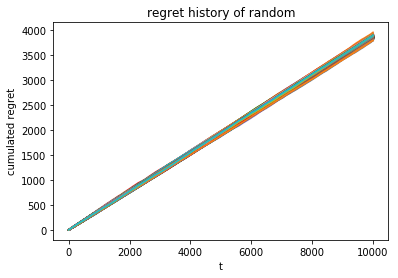

In [ ]:
stgy_name = 'random'
accum_regrets_2d_random = \
    get_accum_regrets_with_runs_and_times(bandit, player, number_of_runs, number_of_pulls,
                                          stgy_name)
plot_accum_regrets_2d_for_a(accum_regrets_2d_random, stgy_name)

## 2. 貪婪策略

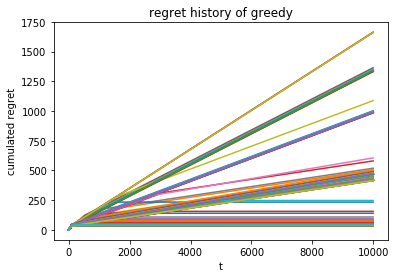

In [ ]:
stgy_name = 'greedy'
num_rand = 100               # 隨機策略的執行個數
accum_regrets_2d_greedy = \
    get_accum_regrets_with_runs_and_times(bandit, player, 
                                          number_of_runs, number_of_pulls, stgy_name,
                                          number_of_random_pull=num_rand)
plot_accum_regrets_2d_for_a(accum_regrets_2d_greedy, stgy_name)

## 3. epsilon-貪婪策略

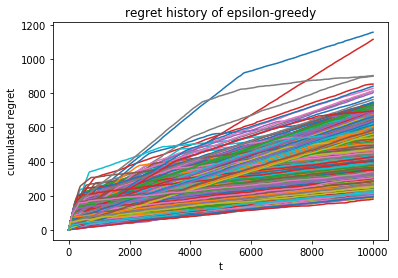

In [ ]:
stgy_name = 'epsilon-greedy'
epsilon = 0.05
accum_regrets_2d_epsilon_greedy = \
    get_accum_regrets_with_runs_and_times(bandit, player, 
                                          number_of_runs, number_of_pulls, stgy_name, 
                                          epsilon=epsilon)
plot_accum_regrets_2d_for_a(accum_regrets_2d_epsilon_greedy, stgy_name)

## 4. 樂觀初始值

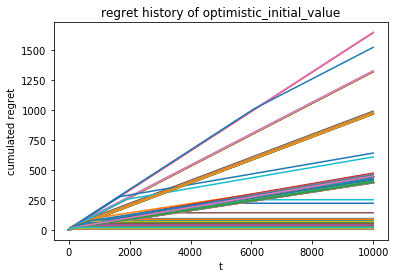

In [ ]:
stgy_name = 'optimistic_initial_value'
initial_value = 1
accum_regrets_2d_optimistic_initial_value = \
    get_accum_regrets_with_runs_and_times(bandit, player, 
                                          number_of_runs, number_of_pulls, stgy_name, 
                                          initial_value=initial_value)
plot_accum_regrets_2d_for_a(accum_regrets_2d_optimistic_initial_value, stgy_name)

## 5. mu + c * sigma / sqrt(N)

In [ ]:
stgy_name = 'average_reward_plus_std'
multiplier = 1.
initial_value = 1.
accum_regrets_2d_average_reward_plus_std = \
    get_accum_regrets_with_runs_and_times(bandit, player, 
                                          number_of_runs, number_of_pulls, stgy_name, 
                                          multiplier=multiplier, initial_value=initial_value)
plot_accum_regrets_2d_for_a(accum_regrets_2d_average_reward_plus_std, stgy_name)

## 6. UCB (Upper Confidence Bound)

In [ ]:
stgy_name = 'upper_confidence_bound'
upper_bound = 1
lower_bound = 0
accum_regrets_2d_upper_confidence_bound = \
    get_accum_regrets_with_runs_and_times(bandit, player, 
                                          number_of_runs, number_of_pulls, stgy_name, 
                                          upper_bound=upper_bound, lower_bound=lower_bound)
plot_accum_regrets_2d_for_a(accum_regrets_2d_upper_confidence_bound, stgy_name)

## 繪製所有策略的 average accumulated regrets

In [ ]:
accum_regrets_2d_dict = {
    # 'random': accum_regrets_2d_random,
    'greedy': accum_regrets_2d_greedy,
    'epsilon-greedy': accum_regrets_2d_epsilon_greedy,
    'optimistic_initial_value': accum_regrets_2d_optimistic_initial_value,
    'average_reward_plus_std': accum_regrets_2d_average_reward_plus_std,
    'upper_confidence_bound': accum_regrets_2d_upper_confidence_bound
}
plot_average_accum_regrets(accum_regrets_2d_dict)